In [ ]:
# train and save the model first time

# !pip install 'lightning-flash[image]'

import torch

import flash
from flash.image import ImageClassificationData, ImageClassifier

# 1. Create the DataModule
datamodule = ImageClassificationData.from_folders(
    train_folder="./archive/vinted_train",
    val_folder="./archive/vinted_val",
    batch_size=4,
    num_workers=6,
    transform_kwargs={"image_size": (100, 100), "mean": (0.485, 0.456, 0.406), "std": (0.229, 0.224, 0.225)},
)

# 2. Build the task
model = ImageClassifier(backbone="mobilenetv3_small_100", labels=datamodule.labels)

# 3. Create the trainer and finetune the model
#trainer = flash.Trainer(max_epochs=3, gpus=torch.cuda.device_count())
trainer = flash.Trainer(max_epochs=3, gpus=1)
#trainer = flash.Trainer(max_epochs=3, tpu_cores=8)
trainer.finetune(model, datamodule=datamodule, strategy="freeze")

#save model
trainer.save_checkpoint("image_classification_model.pt")

In [11]:
# Reload model and train extra epochs
import torch
import flash
from flash.image import ImageClassificationData, ImageClassifier
from torchmetrics.functional import accuracy
import os

datamodule = ImageClassificationData.from_folders(
    train_folder="./archive/vinted_train",
    val_folder="./archive/vinted_val",
    batch_size=4,
    num_workers=6,
    transform_kwargs={"image_size": (100, 100), "mean": (0.485, 0.456, 0.406), "std": (0.229, 0.224, 0.225)},
)

trainer = flash.Trainer(max_epochs=20, gpus=1)
model = ImageClassifier.load_from_checkpoint("image_classification_model.pt")

trainer.finetune(model, datamodule=datamodule, strategy="freeze")
trainer.save_checkpoint("image_classification_model.pt")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Using 'mobilenetv3_small_100' provided by rwightman/pytorch-image-models (https://github.com/rwightman/pytorch-image-models).
No pretrained weights exist for this model. Using random initialization.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type           | Params
-------------------------------------------------
0 | train_metrics | ModuleDict     | 0     
1 | val_metrics   | ModuleDict     | 0     
2 | test_metrics  | ModuleDict     | 0     
3 | adapter       | DefaultAdapter | 1.5 M 
-------------------------------------------------
33.6 K    Trainable params
1.5 M     Non-trainable params
1.5 M     Total params
6.158     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 21562/21562 [4:51:40<00:00,  1.23it/s, loss=2.08, v_num=9, train_accuracy_step=0.000, train_cross_entropy_step=3.600, val_accuracy=0.408, val_cross_entropy=1.970, train_accuracy_epoch=0.395, train_cross_entropy_epoch=2.000]     


In [12]:
# this cell loads and tests the model on the test set
import torch
import flash
from flash.image import ImageClassificationData, ImageClassifier
from torchmetrics.functional import accuracy
import os

testfiles = []
dirlabels = []
for directory, _, files in os.walk("./archive/vinted_test_only"):
    for file in files:
        if file.endswith(".jpeg"):
            testfiles.append(os.path.join(directory, file))
            dirlabels.append(directory.split("/")[-1])

datamodule = ImageClassificationData.from_files(
    predict_files=testfiles,
    batch_size=1,
    num_workers=6,
    transform_kwargs={"image_size": (100, 100), "mean": (0.485, 0.456, 0.406), "std": (0.229, 0.224, 0.225)},
)

trainer = flash.Trainer(max_epochs=1, gpus=1)
model = ImageClassifier.load_from_checkpoint("image_classification_model.pt")

predictions = trainer.predict(model, datamodule=datamodule, output="labels")


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Using 'mobilenetv3_small_100' provided by rwightman/pytorch-image-models (https://github.com/rwightman/pytorch-image-models).
No pretrained weights exist for this model. Using random initialization.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 16419/16419 [07:53<00:00, 34.70it/s]


In [13]:
# this cell saves the predictions from the cell above to a csv file
import pandas as pd

"add the datamodule labels and the predictions to a new dataframe"
df = pd.DataFrame({"real_img": dirlabels, "pred_img": predictions})
df.to_csv('predictions.csv', index=False)

In [15]:
# this cell loads the predictions from the csv file and prints the accuracy
import numpy as np
from sklearn import preprocessing

df = pd.read_csv('predictions.csv')

"convert the dataframe values to integers using sklearn labelencoder"
df = df.apply(preprocessing.LabelEncoder().fit_transform)

"create torch tensors from the dataframe"
target_tens = torch.tensor(df['real_img'])
preds_tens = torch.tensor(df['pred_img'])


acc = accuracy(preds_tens, target_tens)
print(acc)

tensor(0.0540)


In [16]:
# this cell loads the predictions from the csv file and prints the f1 score
datamodule = ImageClassificationData.from_folders(
    train_folder="./archive/vinted_train",
    val_folder="./archive/vinted_val",
    batch_size=4,
    num_workers=6,
    transform_kwargs={"image_size": (100, 100), "mean": (0.485, 0.456, 0.406), "std": (0.229, 0.224, 0.225)},
)

le = preprocessing.LabelEncoder()
le.fit(datamodule.labels)

from torchmetrics import F1Score
f1 = F1Score(num_classes=len(le.classes_))
f1(preds_tens, target_tens)

tensor(0.0540)

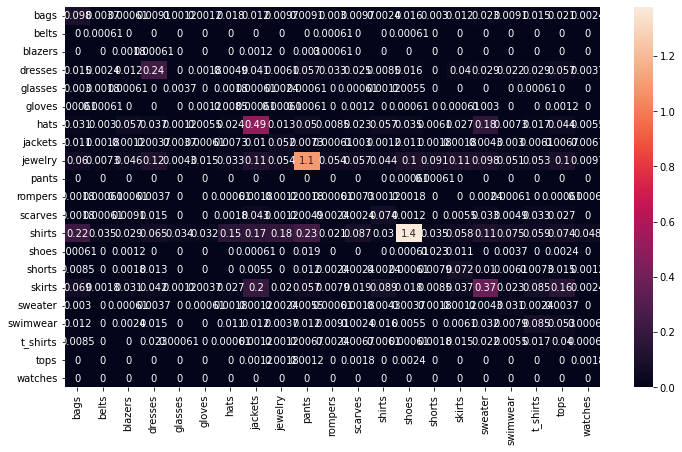

In [17]:
# confusion matrix using pytorch
from torchmetrics import ConfusionMatrix
confmat = ConfusionMatrix(num_classes=len(le.classes_))
confmat(preds_tens, target_tens)


# confusion matrix using sklearn, plot is not usable
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(preds_tens, target_tens)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in le.classes_],
                     columns = [i for i in le.classes_])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')